In [1]:
%load_ext autoreload
%autoreload 2
from notebook_utils import *

import warnings
warnings.filterwarnings('ignore')

# PLOTTING
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":2.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)
cmap=plt.cm.viridis
savedir= '/data/rcp/odeformer/figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

gpu_index = get_most_free_gpu()

parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)        
args = parser.parse_args(args=[])
args.debug = False
env = FunctionEnvironment(args)


In [2]:
runs = []
logs = []
global_path = '/data/rcp/odeformer/experiments'

paths = [
    #'dropout'
    #'int_base'
    #'precision'
    #"curriculum"
    #"first"
    #"second"
    #"use_cross_attention"
    #"third"
    #"fixed_init_scale"
    #"two_hot"
    #"sympy"
    #"mlm"
    #"scale"
    #"poly_new"
    #"bounded"
    #"masked"
    #"general"
    #"general_noise",
    "no_subsampling"
    #"final_evals_2"
       ]


NaN = np.nan
Infinity = np.nan

for path in paths:
    path = os.path.join(global_path, path)
    path = path.rstrip('/') + '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        #try : 
        latest, latest_pmlb, latest_osc = -1, -1, -1
        run = {}
        args = pickle.load(open(dirname+'/params.pkl', 'rb'))
        run['args'] = args
        run['logs'] = []
        run['pmlb'] = []
        run['oscillators'] = []
        run['num_params'] = []
        logfile = dirname+'/train.log'
        f = open(logfile, "r")
        for line in f.readlines():
            if '__log__' in line or '__pmlb__' in line or '__oscillators__' in line: 
                try: log = eval(line[line.find('{'):].rstrip('\n'))
                except:
                    print(line)
                epoch = log['epoch']
                if '__pmlb__' in line:
                    if epoch <= latest_pmlb: continue
                    latest_pmlb = epoch
                    run['pmlb'].append(log)
                elif '__oscillators__' in line:
                    if epoch <= latest_osc: continue
                    latest_osc = epoch
                    run['oscillators'].append(log)
                else:
                    if epoch <= latest: continue
                    latest = epoch
                    run['logs'].append(log)
        f.close()
        args.output_dir = Path(dirname)
        runs.append(run)
    print('{} fails'.format(fails))
    
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

/data/rcp/odeformer/experiments/no_subsampling/
4 runs found
/data/rcp/odeformer/experiments/no_subsampling/exp_train_noise_gamma_0_train_subsample_ratio_0
/data/rcp/odeformer/experiments/no_subsampling/exp_train_noise_gamma_0_train_subsample_ratio_0.5
/data/rcp/odeformer/experiments/no_subsampling/exp_train_noise_gamma_0.1_train_subsample_ratio_0
/data/rcp/odeformer/experiments/no_subsampling/exp_train_noise_gamma_0.1_train_subsample_ratio_0.5
0 fails


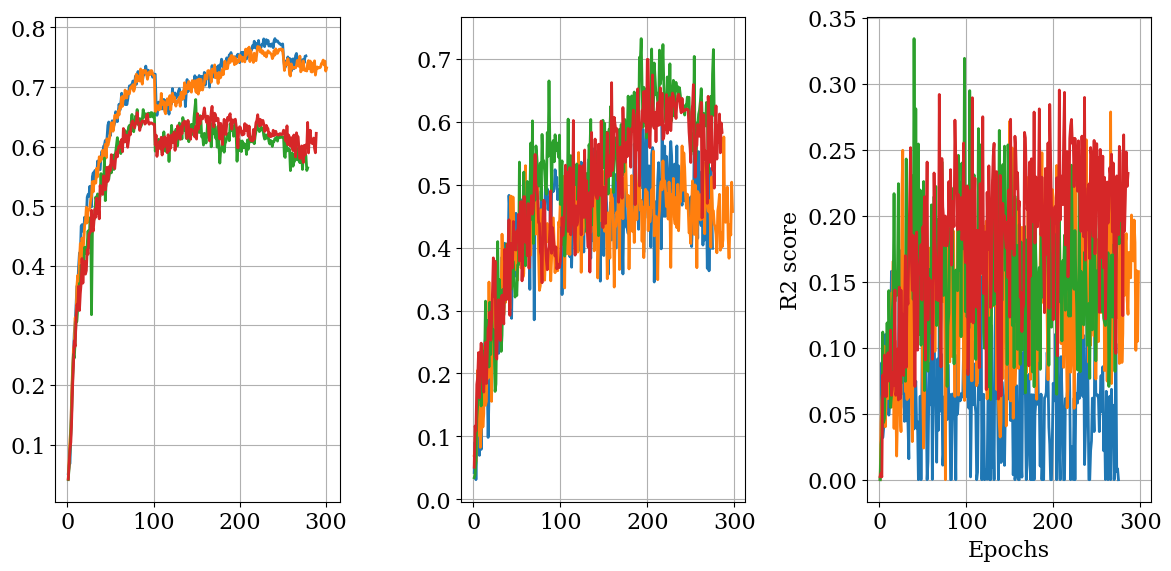

In [4]:
constraints = {
    #'optimizer': ['adam_cosine,warmup_updates=5000,init_period=50000,period_mult=1.5,lr_shrink=0.5'],
}
selected_runs, selected_params = select_runs(runs, params, constraints)
latest = min([len(run['logs'])-1 for run in selected_runs])
#selected_runs = runs

fig, axarr = plt.subplots(1,3,figsize=(12,6))

for i, mode in enumerate(['logs', 'pmlb', 'oscillators']): 
    for run in selected_runs[:]:
        args = run['args']
        times = np.array(range(len(run[mode])))#[:latest]
        r2    = [run[mode][t]['r2_zero']      for t in times]
        acc    = [run[mode][t]['term_difference']      for t in times]
        label = args.exp_id
        #label = 'dim {}'.format(lab)
        y = r2
        #print(loss,correct,perfect,additional)
        axarr[i].plot(times+1, y, label=label)

#plt.legend()
plt.xlabel('Epochs')
plt.ylabel('R2 score')
#plt.xscale('log')

plt.tight_layout()
#plt.savefig(savedir+'simplification_loss_{}.pdf'.format('float' if args.float_sequences else 'int'))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


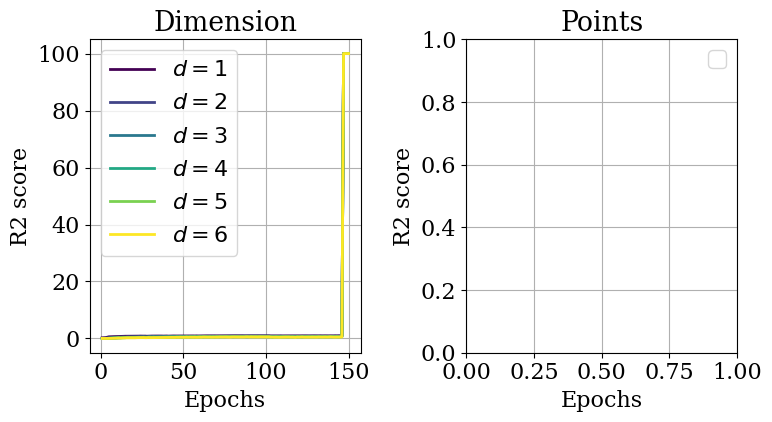

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


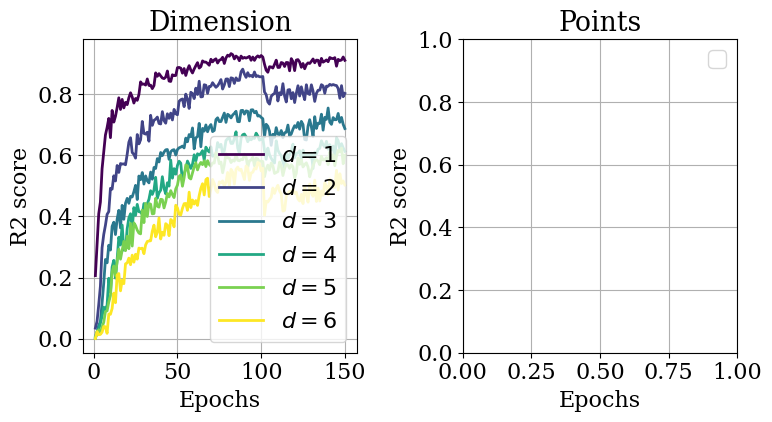

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


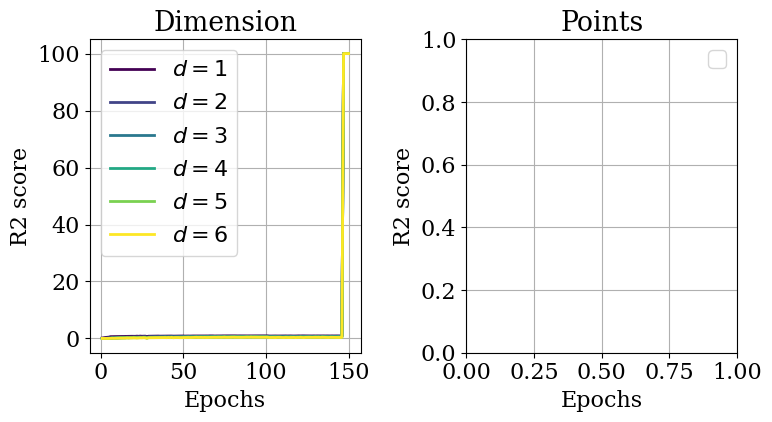

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


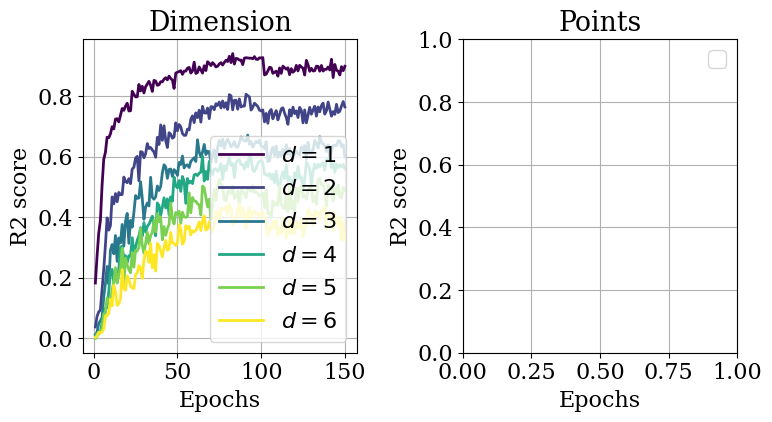

In [5]:
metric = 'r2_zero'
infos = ['dimension', 'n_points'] #'n_unary_ops', 
metrics = [metric+'_info_'+info for info in infos]
legends = ['d', 'n'] #'o', 
labels = ['Dimension', 'Points'] #'Number of unary operators', 

#selected_runs = [runs[0],runs[-1]]

for run in selected_runs:
    if not run['logs']:continue
    args = run['args']
    fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
    for i, metric in enumerate(metrics):
        keys = [k for k in run['logs'][0].keys() if metric in k]
        keys = keys[::max(1,len(keys)//5)]
        for j, key in enumerate(keys):
            label = int(key.split('_')[-1])
            if metric == 'additional': label = args.more_tolerance.split(',')[int(label)-1]
            for t in range(len(run['logs'])):
                if key not in run['logs'][t]: run['logs'][t][key] = 100
            acc = [run['logs'][t][key] for t in range(len(run['logs']))][:150]
            axarr[i].plot(range(1, len(acc)+1), acc, label='${}={}$'.format(legends[i],label), color = cmap(j/(len(keys)-1)))
        axarr[i].set_title(labels[i])
        axarr[i].legend()
    for ax in axarr:
        #ax.set_xscale('log')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('R2 score')
    #for n, ax in enumerate(axarr):
    #    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
    plt.tight_layout()
    plt.savefig(savedir+'acc_vs_time.pdf')
    plt.show()      

/data/rcp/odeformer/experiments/final_evals_2/exp_eval_noise_gamma_0_eval_subsample_ratio_0_beam_size_10
/data/rcp/odeformer/experiments/final_evals_2/exp_eval_noise_gamma_0_eval_subsample_ratio_0.1_beam_size_10
/data/rcp/odeformer/experiments/final_evals_2/exp_eval_noise_gamma_0.05_eval_subsample_ratio_0_beam_size_10
/data/rcp/odeformer/experiments/final_evals_2/exp_eval_noise_gamma_0.05_eval_subsample_ratio_0.1_beam_size_10


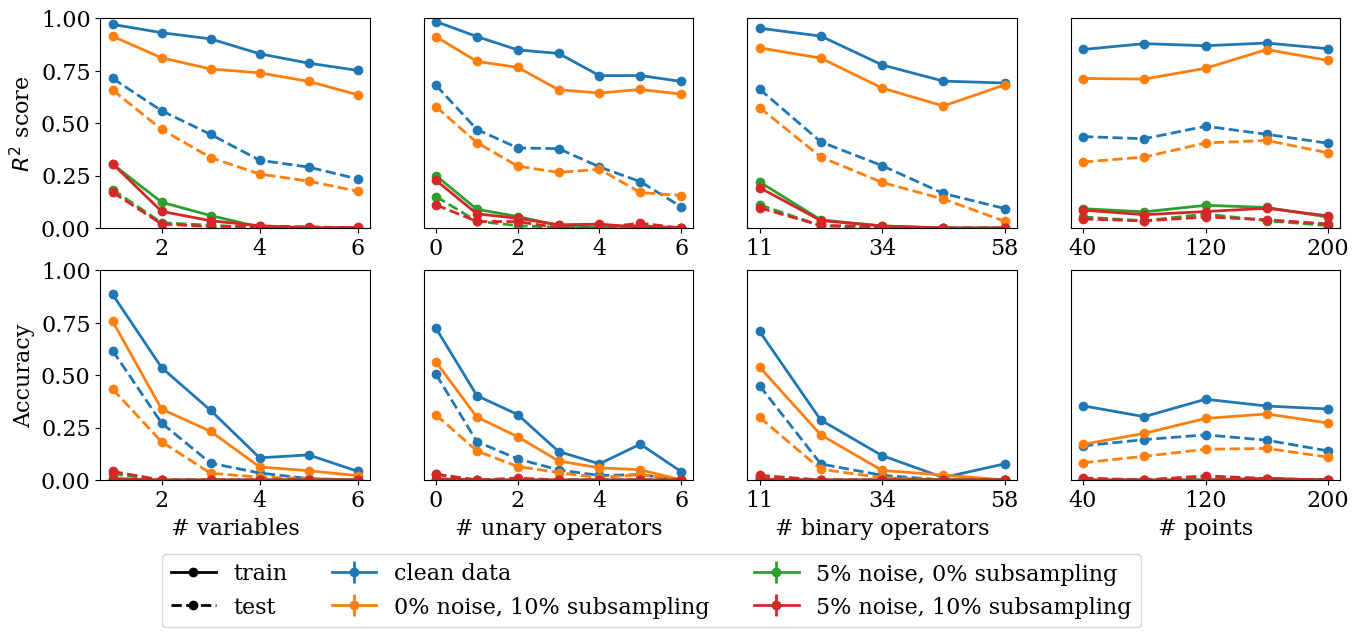

In [4]:
metrics = {'r2_zero':'$R^2$ score', 'accuracy_l1_biggio': 'Accuracy'}#, 'term_difference':'Term difference'}#, 'accuracy_l1_biggio']
#metrics = {'test_r2_zero':'$R^2$ score', 'test_accuracy_l1_biggio': 'Accuracy'}#, 'term_difference':'Term difference'}#, 'accuracy_l1_biggio']
ablations = {'info_dimension':'# variables', 'info_n_unary_ops':'# unary operators', 'info_n_binary_ops': '# binary operators', 'info_n_points':'# points'}


# plot r2_zero vs info_n_points
fig, axarr = plt.subplots(len(metrics), len(ablations), figsize=(4*len(ablations),len(metrics)*3))
if len(metrics) == 1: axarr = [axarr]
irun = 0
for _, run in enumerate(runs[:]):
    args = run['args']
    if args.beam_size!=10: continue
    if args.eval_noise_gamma == 0 and args.eval_subsample_ratio == 0: label='clean data'
    else: label = f'{int(100*args.eval_noise_gamma)}% noise, {int(100*args.eval_subsample_ratio)}% subsampling'
    try:
        df = pd.read_csv(args.output_dir/'evals_all/eval_in_domain.csv')
    except:
        print("Skipped"); continue
    print(args.output_dir)
    df = df.drop(columns=['predicted_trees', 'trees'])
    df = df.query('info_n_unary_ops <7')
    k = 5# bin info_n_points into k bins
    for ablation in ['info_n_points', 'info_n_binary_ops']:
        df[ablation] = pd.cut(df[ablation], bins=k, labels=(np.arange(1,k+1)*df[ablation].max()/k).astype(int))
    for i, (metric, metric_name) in enumerate(metrics.items()):
        for j, (ablation, ablation_name) in enumerate(ablations.items()):
            std = 0#df.groupby(ablation)[metric].std()
            df.groupby(ablation)[metric].mean().plot(ax=axarr[i][j], marker='o', yerr=std, label=label, color=f'C{irun}')
            df.groupby(ablation)['test_'+metric].mean().plot(ax=axarr[i][j], marker='o', yerr=std, ls='--', color=f'C{irun}', label='')
            axarr[i][j].set_ylim(0,1)
            if j>0: axarr[i][j].set_yticks([])
            #axarr[i,j].set_xscale('log')
            axarr[i][j].grid(False)
            axarr[i][j].set_xlabel("")
            axarr[-1][j].set_xlabel(ablation_name)
            axarr[i][0].set_ylabel(metric_name)
    irun += 1

axarr[-1][-1].plot([],[], marker='o', color='k', label='train')
axarr[-1][-1].plot([],[], marker='o', color='k', label='test', ls='--')
plt.legend(bbox_to_anchor=(0.3,-0.3), ncol=3)
plt.tight_layout()
plt.savefig(savedir+'acc_vs_info.pdf')
plt.show()


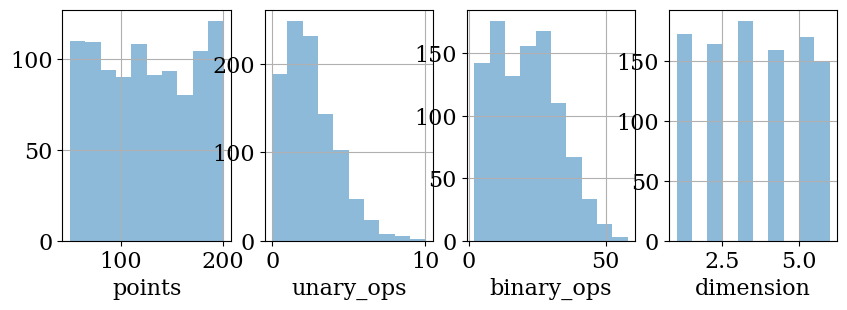

In [6]:
# plot r2_zero vs info_n_points
run = runs[0]
args = run['args']
df = pd.read_csv(args.output_dir/'evals_all/eval_in_domain.csv')
info_columns = [col for col in df.columns if col.startswith('info_')]
for run in selected_runs[:1]:
    fig, axarr = plt.subplots(1, len(info_columns), figsize=(10,3))
    args = run['args']
    df = pd.read_csv(args.output_dir/'evals_all/eval_in_domain.csv')
    # plot histograms for all info columns
    for i, col in enumerate(info_columns):
        df[col].hist(ax=axarr[i], alpha=0.5, label=col)
        axarr[i].set_xlabel(col.lstrip('info_'))
    


In [7]:
run = runs[0]
args = run['args']
df = pd.read_csv(args.output_dir/'evals_all/eval_in_domain.csv')
#df = pd.read_csv(args.output_dir/'evals_all/eval_pmlb.csv')
#df = df.query('info_n_masked_variables==1')
df = df.query('info_dimension==1')
#df = df.query('r2_zero>0.99')
for i, (_, sample) in enumerate(df.iterrows()):
    if i==10: break
    try:
        print(sample['r2_zero'], sample['term_difference'])
        if hasattr(sample, 'trees'):
            print(''.join(['{:>80s}'.format(eq) for eq in sample['trees'].split('|')]))
        print(''.    join(['{:>80s}'.format(eq) for eq in sample['predicted_trees'].split('|')]))
        print()
    except: pass

0.9999945713280172 0.0
                                                                   -6.4582 * x_0
                                                                   -6.4810 * x_0

0.9899890091383274 0.0
                                                              -0.0419 * (x_0)**2
                                                              -0.0430 * (x_0)**2

0.9999902699098356 0.0
                                                                  -11.7668 * x_0
                                                                  -11.9000 * x_0

0.9996999937261556 0.6666666666666666
0.1135 * sin(-0.0820 + 0.9464 * x_0) + 5.52990 * (x_0)**2 + 0.401494 * (x_0)**4 + -1.2577 * x_0 + -4.02099 * (x_0)**3
    0.1020 * (-11.7500 + -10.0500 * x_0)**-1 + 8.7250 * (x_0)**2 + -1.0060 * x_0

0.9891867276807268 1.3333333333333333
                                      1.2866 + 0.3527 * x_0 + -0.2553 * (x_0)**2
                             1.4830 * sin(1.0160 + 0.6481 * x_0) + -0.0683 * x_0

0.9

# Load model

In [3]:
run = runs[-1]
args = run['args']
extra_args = {
    'reload_checkpoint':run['args'].dump_path.replace('/sb_u0621_liac_scratch','/data/rcp'),
    'reload_data':run['args'].reload_data.replace('/sb_u0621_liac_scratch','/data/rcp'),
    'rescale':True,
    'subsample_ratio':0,
              }
with stdout_redirected():
    dstr = load_run(run, extra_args=extra_args)

Reloading checkpoint from /data/rcp/odeformer/experiments/no_subsampling/exp_train_noise_gamma_0.1_train_subsample_ratio_0.5/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 292 / iteration 876000 ...


In [5]:
import symbolicregression
from symbolicregression.model import SymbolicTransformerRegressor

dstr = SymbolicTransformerRegressor(
    from_pretrained=True,
    rescale=True)

Loaded pretrained model


In [4]:
dstr.rescale=True
dstr.average_trajectories=False

dstr.model.beam_type = 'sampling'
dstr.model.beam_size = 20
dstr.model.beam_temperature = .1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-2.9748*x_0*x_1 + 2.9559*x_0

1.0102*x_1*(2.963*x_0 - 3.082)

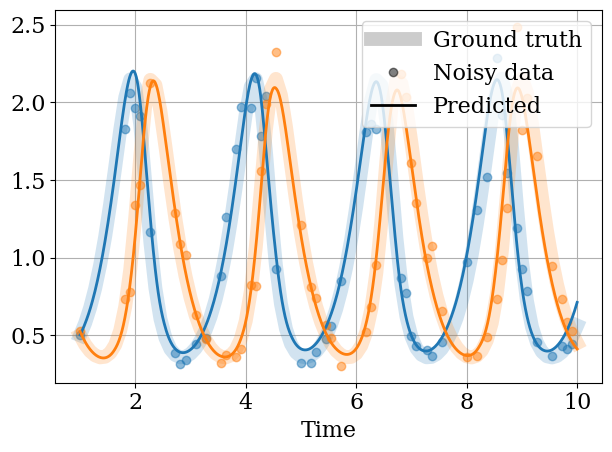

-7.9372*x_0 + 7.5801*x_1

6.3322*x_0*(-0.0057*x_0 + 2.1*sin(0.1177*x_2 + 0.1005))

1.24*x_1**2 - 4.1732*x_2

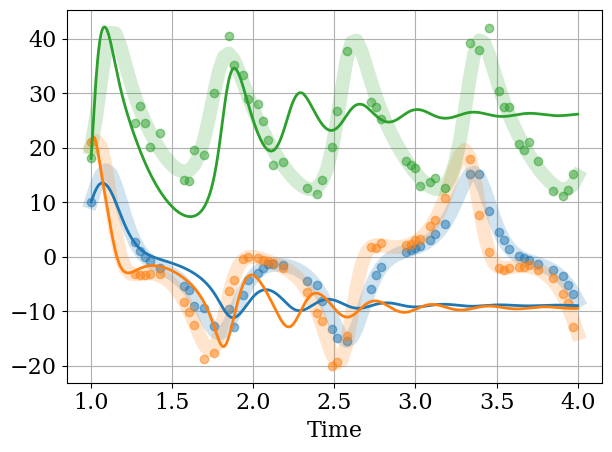

0.0606*x_0 + 0.0133/(1.071 - 0.3169*x_0)

-1.5153*x_1

-0.0997*x_0 + 10.3654*(x_2 - 0.1548)**2

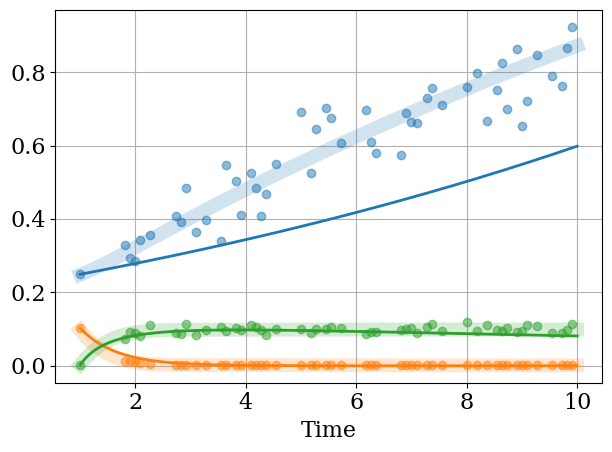

-0.0021*x_0**2

-1.7509*x_1**2

0.2183*x_1

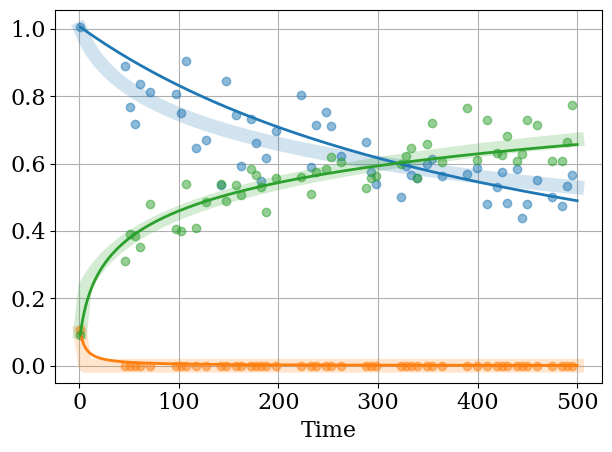

-0.0544*x_0

-1.0876*x_0 - 1.0648*x_1

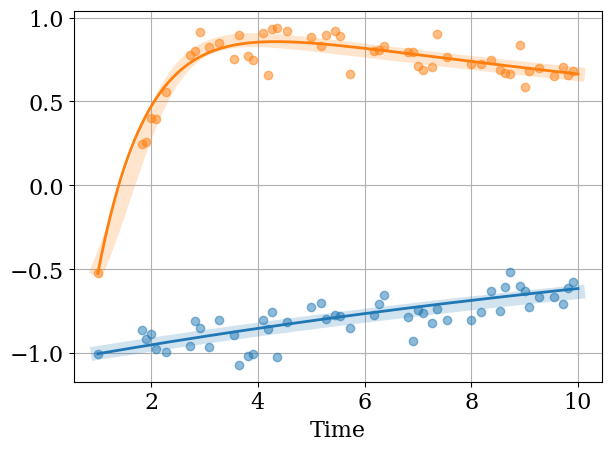

1.7471*x_1**3 - 0.1971*x_1**2 + 0.1102*x_1

-0.525*x_0**2*(3.6694*x_0 + 1.0728*x_1)

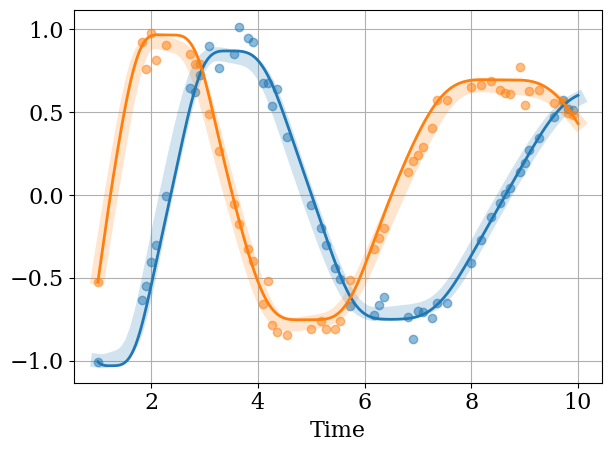

0.8997*x_1

-1.3976*x_0**2*x_1 - 0.9968*x_0 + 1.192*x_1

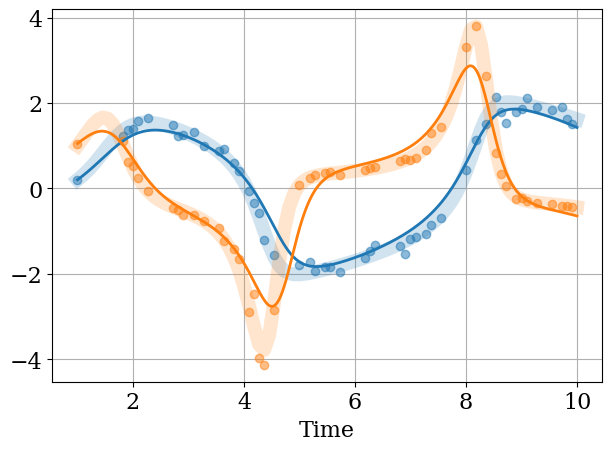

0.9865*x_1

-2.6863*x_0

-0.1238*x_1*(-0.3037*x_1 - 0.5597*x_2)

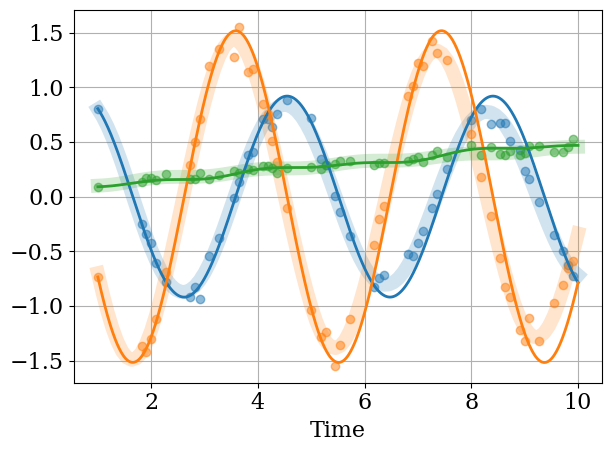

In [12]:
from ode_systems import *
# autoreload
%load_ext autoreload
%autoreload 2

def predict(system=lv_system, seed=1, n_trajectories=1):

    name, function, labels, y0, n_points, tmax = system['name'], system['function'], system['labels'], system['init'], system['n_points'], system['tmax']
    dimension = len(y0)
    
    # solve ODE
    times, trajectories = [],[]
    np.random.seed(seed)
    for _ in range(n_trajectories):
        time = np.linspace(1,tmax,n_points)     # time
        #y0 = np.array([.5]*dimension)
        #y0 = np.random.uniform(0,1,size=(dimension,)) # initial conditions
        trajectory = integrate.odeint(function, y0, time)
        plot_time = np.linspace(min(time),max(time),1000)     # time
        original_time = time.copy()
        original_trajectory = trajectory.copy()
        time, trajectory, _ = env._subsample_trajectory(time, trajectory, np.random.RandomState(seed), subsample_ratio=0.5)
        noise, _ = env._create_noise(train=False, trajectory=trajectory, gamma=0.1)
        trajectory += noise
        #trajectory *= (1+.1*np.random.randn(*trajectory.shape))
        times.append(time)
        trajectories.append(trajectory)

    plt.figure()
    for dim in range(dimension):
        plt.plot(original_time, original_trajectory[:,dim], color=f'C{dim}', alpha=.2, lw=10)
        plt.plot(time, trajectory[:,dim], ls="None", marker='o', alpha=.5, color=f'C{dim}')
    if system == lv_system:
        plt.plot([],[], color='k', alpha=.2, lw=10, label='Ground truth')
        plt.plot([],[], color='k', alpha=.5, ls="None", marker='o', label='Noisy data')
        plt.plot([],[], color='k', label='Predicted')
        plt.legend()

    candidates = dstr.fit(times, trajectories, verbose=False)

    for i, tree in enumerate(candidates[0][:1]):
        sympy_trees = env.simplifier.tree_to_sympy_expr(tree)
        for sympy_tree in sympy_trees:
            display(sympy_tree)

        pred_trajectory = integrate_ode(trajectories[0][0], plot_time, tree, "solve_ivp", debug=True)
        try:
            for dim in range(dimension):
                plt.plot(plot_time, pred_trajectory[:,dim])# label=labels[dim])
        except: 
            print(traceback.format_exc())
    plt.xlabel('Time')
    #plt.ylabel('Values')
    plt.tight_layout()
    #plt.savefig(savedir+f'{name}.pdf')
    plt.show()

    return trajectory, pred_trajectory

systems = my_ode_systems
#systems = [lorenz_system]
for system in systems:
    trajectory, pred_trajectory = predict(system=system, seed=4)
    if system == 'lorenz_system':
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
        ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], label="Ground truth")
        ax.plot(pred_trajectory[:,0], pred_trajectory[:,1], pred_trajectory[:,2], label="Prediction")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.legend()
        plt.tight_layout()
        #plt.savefig(savedir+'lorenz_traj.pdf')


10.7100 * x_0 + -3.2060 * (x_0)**2


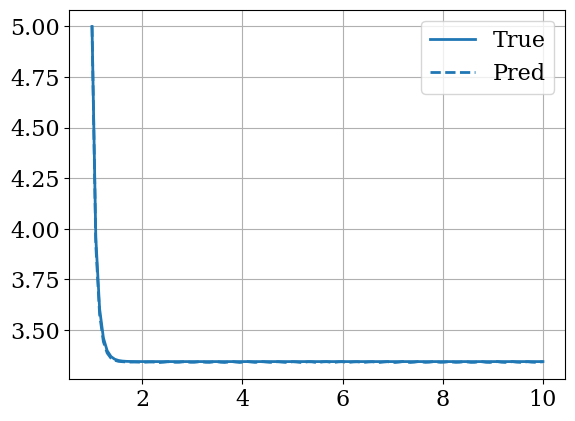

In [15]:
dstr.rescale=True
a = -3
b = 10
c = .1
def quadratic(X, t):
    return np.array([a*X[0]**2+b*X[0]+c])

# solve ODE
times = np.linspace(1, 10, 120)     # time
y0 = [5] # initials conditions
trajectory = integrate.odeint(quadratic, y0, times)
# plot results
plt.plot(times, trajectory[:,0], color='C0', label='True')

candidates = dstr.fit(times, trajectory)
tree = candidates[0][0]
for tree in candidates[0][:1]:
    print(tree)
    pred_trajectory = integrate_ode(y0,times, tree, "solve_ivp")
    plt.plot(sorted(times), pred_trajectory[:,0], color='C0', ls='--', label='Pred')
plt.legend()
plt.show()

# Benchmarks

## Strogatz

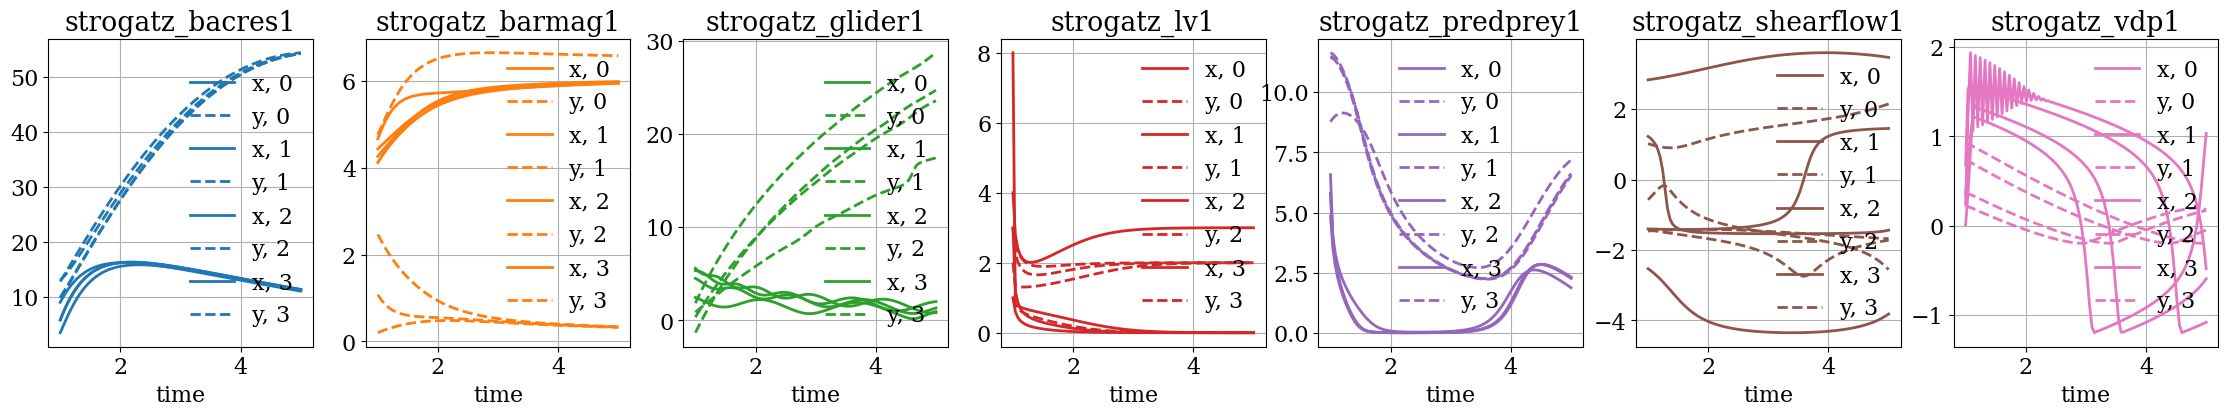

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from pmlb import fetch_data, dataset_names
strogatz_names = [name for name in dataset_names if "strogatz" in name and "2" not in name]
n = len(strogatz_names)
strogatz_equations = {
    "bacres"   :["(20 - x_0 - x_0*x_1)/(1 + 0.5*x_0**2)", "(10 - x_0*x_1)/(1 + 0.5*x_0**2)"],
    "barmag"   :[" 0.5*sin(x_0 - x_1) - sin(x_0)"       , "0.5*sin(x_1 - x_0) - sin(x_1)"],
    "glider"   :["-0.05 x_0**2 - sin(x_1)"              , "x_0-cos(x_1)/x_0"],
    "predprey" :["x_0*(4 - x_0 - x_1/(1 + x_0))"        , "x_1*(x_0/(1 + x_0) - 0.075*x_1)"],
    "shearflow":["cos(x_0)*cos(x_1)/sin(x_0)"           , "(cos(x_1)**2+0.1*sin(x_1)**2)*sin(x_1)"],
    "vdp"      :["10*(x_1-(x_0**3)/3-x_0)"              , "-x_0/10"],
    "lv"       :["x_0*(3 - x_0 - 2* x_1)"               , "x_1*(2-x_0-x_1)"]
}

times = np.linspace(1, 5, 100)

# Returns a pandas DataFrame
fig, axarr = plt.subplots(1,n,figsize=(n*4,4))
for i ,name in enumerate(strogatz_names):
    data = fetch_data(name)
    x = data['x'].values
    y = data['y'].values
    for j in range(4):
        start = j * len(times)
        stop = (j+1) * len(times)
        axarr[i].plot(times, x[start:stop], color=f"C{i}", ls='-', label=f"x, {j}")
        axarr[i].plot(times, y[start:stop], color=f"C{i}", ls='--', label=f"y, {j}")
    axarr[i].set_xlabel("time")
    axarr[i].legend(ncol=1, loc="best", frameon=False)
    axarr[i].set_title(name)
plt.show()

0 strogatz_bacres1
                          7.1200 * (-0.1720 + 0.0889 * x_0)**-1 + -0.1744 * x_1                                                x_0 * (0.0632 + 0.0800 * x_1)**-1
                                           (20 - x_0 - x_0*x_1)/(1 + 0.5*x_0**2)                                                 (10 - x_0*x_1)/(1 + 0.5*x_0**2)
1 strogatz_barmag1
                                                   1.1810 * x_1 + -1.3300 * x_0                                 1.5430 * x_1 + -0.2174 * (-0.2461 + -1 * x_1)**2
                                                   0.5*sin(x_0 - x_1) - sin(x_0)                                                   0.5*sin(x_1 - x_0) - sin(x_1)
2 strogatz_glider1
                                                             -0.0708 * (x_0)**2                                                                     1.3110 * x_0
                                                         -0.05 x_0**2 - sin(x_1)                                                          

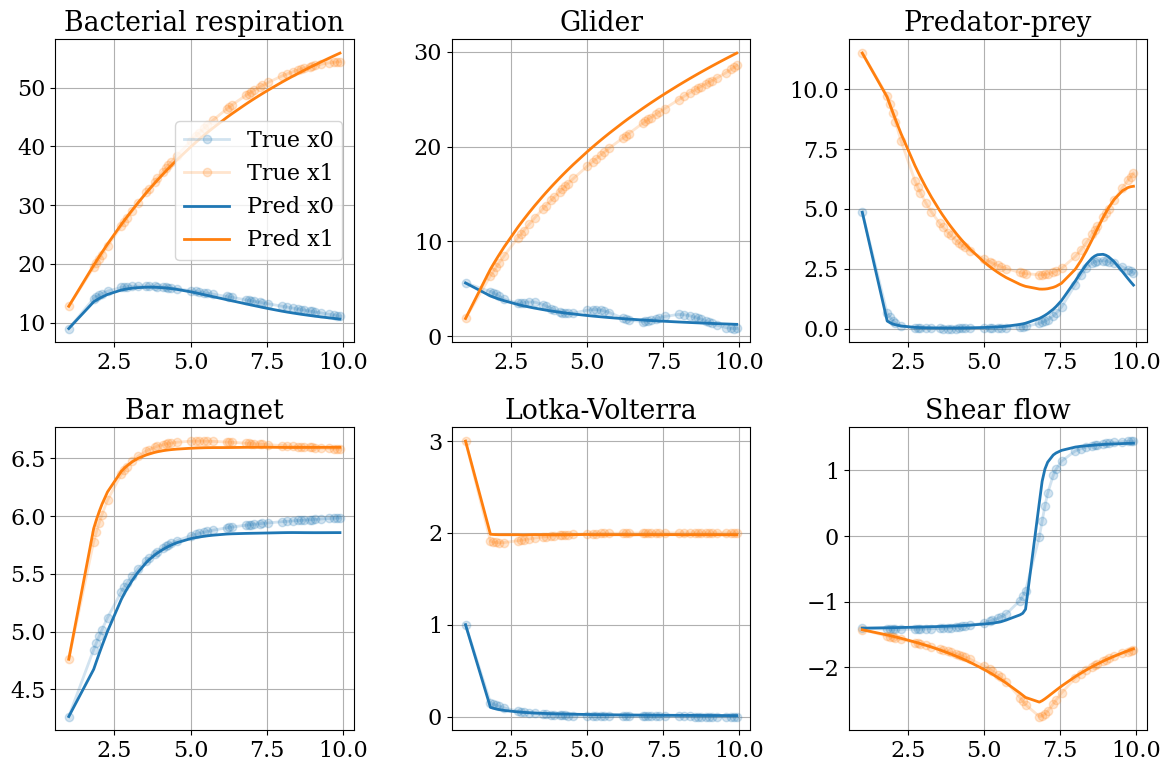

In [66]:
n = len(strogatz_names)
fig, axarr = plt.subplots(2,n//2,figsize=(4*(n//2),4*2))
dstr.rescale = False
dstr.average_trajectories = False
dstr.model.beam_size = 100
dstr.model.beam_temperature = .5
titles = ['Bacterial respiration', 'Bar magnet', 'Glider', 'Lotka-Volterra', 'Predator-prey', 'Shear flow', 'Van der Pol']

time = np.linspace(1, 10, 100)
for i ,name in enumerate(strogatz_names[::]):
    for strogatz_name, strogatz_tree in strogatz_equations.items():
        if strogatz_name in name: break
    data = fetch_data(name)
    print(i, name)
    times, trajectories = [], []
    for j in range(1):
        x = data['x'].values.reshape(-1,1)[j*100:(j+1)*100]
        y = data['y'].values.reshape(-1,1)[j*100:(j+1)*100]
        trajectory = np.concatenate((x,y), axis=1)
        time_, trajectory_ = env._subsample_trajectory(time, trajectory, subsample_ratio=0.5)
        trajectories.append(trajectory_)
        times.append(time_)

    ax_idx = (i%2, i//2)
    if i//2 == n//2: continue

    for dim in range(len(trajectory[0])):
        axarr[ax_idx].plot(times[0], trajectories[0][:,dim], marker='o', label=f'True x{dim}', alpha=.2)
    candidates = dstr.fit(times, trajectories, verbose=False)
    #candidates[0] = dstr.sort_candidates(times[0], trajectories[0], candidates[0][:5], "complexity")

    for tree in candidates[0][:1]:
        tree = env.simplifier.simplify_tree(tree)
        try:
            print(''.join(['{:>80s}'.format(eq) for eq in tree.infix().split('|')]))
            print(''.join(['{:>80s}'.format(eq) for eq in strogatz_tree]))
            pred_trajectory = integrate_ode(trajectories[0][0], times[0], tree, "solve_ivp", debug=False)
            for dim in range(len(trajectory[0])):
                axarr[ax_idx].plot(times[0], pred_trajectory[:,dim], color=f'C{dim}', label=f'Pred x{dim}')
        except: 
            print(traceback.format_exc())
    axarr[ax_idx].set_title(titles[i])
axarr[0, 0].legend()
plt.tight_layout()
plt.savefig(savedir+"strogatz.pdf")

plt.show()


## Dynobench

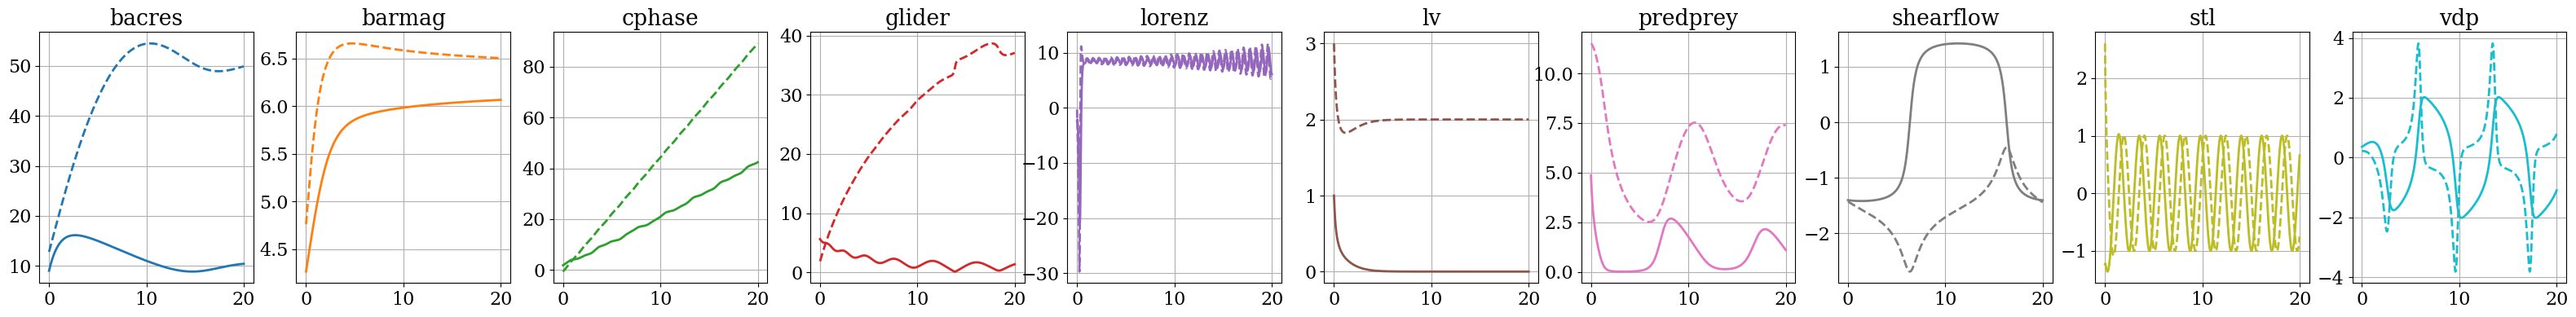

In [78]:
path = '/data/rcp/odeformer/dynobench/data/dense/'
n = len(glob.glob(path+'*'))
fig, axarr = plt.subplots(1,n,figsize=(n*4,4))
for i, name in enumerate(glob.glob(path+'*')):
    file = os.listdir(name)[-4]
    data = pd.read_csv(name+'/'+file)
    times, x, y = data['t'].values, data['x'].values, data['y'].values
    trajectory = np.concatenate((x,y), axis=1)
    #axarr[i].plot(t, x, color=f"C{i}", ls='-', label=f"x")
    #axarr[i].plot(t, y, color=f"C{i}", ls='--', label=f"y")
    #axarr[i].set_title(name.split('/')[-1])

0 /data/rcp/odeformer/dynobench/data/dense/bacres
0.1695 * sin(-18.8000 + 1.1961 * x_0) + 0.3626 * sin(-11.6300 + 0.1663 * x_1) + 26.6704 * (-1.0510 + 0.2853 * x_1)**-1 + -0.2261 * x_0             0.5568 * x_0 + 0.6816 * (-1.1960 + 0.1262 * x_1)**-1 + -0.1066 * x_1
1 /data/rcp/odeformer/dynobench/data/dense/barmag
                                              0.5299 * x_0 + -0.0879 * (x_0)**2        0.0906 * sin(0.1741 + 2.9462 * x_0) + 0.1430 * sin(1.1480 + 3.9653 * x_1)
2 /data/rcp/odeformer/dynobench/data/dense/cphase
    2.4664 * sin(7.1990 + 0.0163 * x_0) + -1.4921 * sin(-0.1125 + 4.6221 * x_0)                                    -3.3583 * x_0 * (-0.0880 + -0.7490 * x_0)**-1
3 /data/rcp/odeformer/dynobench/data/dense/glider
                     -0.0576 * (x_0)**2 + -1.0884 * sin(-0.0887 + 1.0978 * x_1)                            0.9556 * x_0 + -0.3626 * (0.1732 + -2.2355 * x_0)**-1
4 /data/rcp/odeformer/dynobench/data/dense/lorenz
                                                 15

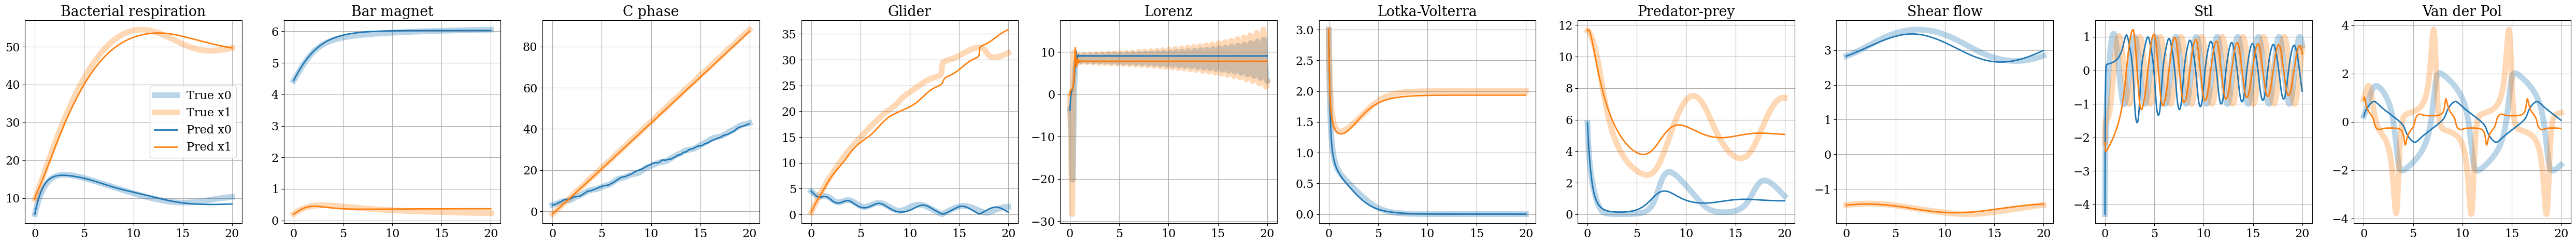

In [12]:
path = '/data/rcp/odeformer/dynobench/data/dense/'
n = len(glob.glob(path+'*'))
titles = ['Bacterial respiration', 'Bar magnet', 'Coupled phase oscillator', 'Glider', 'Lorenz', 'Lotka-Volterra', 'Predator-prey', 'Shear flow', 'Stuart-Landau', 'Van der Pol']


fig, axarr = plt.subplots(1,n,figsize=(n*5,5))
dstr.rescale = True
dstr.average_trajectories = False
dstr.model.beam_size = 5
dstr.model.beam_temperature = .3
dstr.model.beam_length_penalty = 0

for i, name in enumerate(glob.glob(path+'*')):
    times, trajectories = [], []
    print(i, name)

    for j in range(1,5):
        file = os.listdir(name)[-j]
        data = pd.read_csv(name+'/'+file)
        time, x, y = data['t'].values, data['x'].values.reshape(-1,1), data['y'].values.reshape(-1,1)
        if 'lorenz' in name: 
            z = data['z'].values.reshape(-1,1)
            trajectory = np.concatenate((x,y,z), axis=1)
        else:
            trajectory = np.concatenate((x,y), axis=1)
        trajectories.append(trajectory)
        times.append(time)

    for dim in range(len(trajectory[0])):
        axarr[i].plot(times[0], trajectories[0][:,dim], color=f'C{dim}', label=f'True x{dim}',  lw=8, alpha=.3)
    candidates = dstr.fit(times, trajectories, verbose=False)
    #candidates[0] = dstr.sort_candidates(times[0], trajectories[0], candidates[0][:5], "complexity")

    for tree in candidates[0][:1]:
        tree = env.simplifier.simplify_tree(tree)
        try:
            print(''.join(['{:>80s}'.format(eq) for eq in tree.infix().split('|')]))
            pred_trajectory = integrate_ode(trajectories[0][0], times[0], tree, "solve_ivp", debug=False)
            for dim in range(len(trajectory[0])):
                axarr[i].plot(times[0], pred_trajectory[:,dim], color=f'C{dim}', label=f'Pred x{dim}')
        except: 
            print(traceback.format_exc())
    axarr[i].set_title(titles[i])
axarr[0].legend()
plt.tight_layout()
plt.savefig(savedir+"dynobench.pdf")

plt.show()

## Oscillators

In [13]:
datasets = {}
for file in glob.glob("invar_datasets/*"):
    if "real" in file: continue
    with open(file) as f:
        lines = (line for line in f if not line.startswith('%') and not line.startswith('x'))
        data = np.loadtxt(lines)
        data = data[data[:,0]==0]
    datasets[file.split('/')[-1]] = data
n = len(datasets)

0 -1.0021*x_1  ,  0.9826*x_0 - 0.0917/(1.018*x_1 - 1.32)
1 -5.7014*x_2*x_3 + 3.7827*x_2  ,  6.084*x_0**2 - 0.9661*x_1 + 1.425*x_3  ,  0.8492*x_0 + 0.4483*(218.2*x_0 - 0.1554*x_1)*(5.14*x_0 - 3.26*x_1 - 1.127/(1.014*x_0 - 10.28))  ,  10.5019*x_0*(24.14*x_0 - 13.0985*x_1) + 0.0783*x_0
2 1.0568*x_2 + 0.0177/(13.7*x_2 - 1.071)  ,  9.792*x_0 - 7.6887*x_1  ,  -28.4003*x_0**3 - 0.3037*x_0/(0.1281*x_0 + 0.0518)  ,  -0.0584*x_1**2*(-32.4421*x_1*(33.4353*x_1 - 10.77) - 348.7*x_2)
3 1.0158*x_1  ,  0.994*x_2  ,  -3.0128*x_1 - 0.0975*x_2
4 0.9922*x_1  ,  -2.9926*x_0 - 0.097*x_1 + 12.5192
5 -3.7718*sin(100.8*x_1 - 0.0518) + 14.434/(6.4744*x_0 - 13.12)  ,  -10.422*x_1*(-10.05*x_1 + 145814084.529*x_3)  ,  0.9*x_2*(1492.0*x_1 - 510.3*x_2)  ,  0
6 8.9064*x_2 + 1.4787/(-1.1347*x_3 - 0.1248)  ,  -13.779*x_1*(-771.6*x_1 + 1027.0*x_2)  ,  -12.609*x_1*(1069.0*x_1 - 1001.0*x_2)  ,  105.84*x_1
7 -1.1118*x_1 + 0.1617*sin(6.7564*x_1 - 1.036)  ,  0.9804*x_0 - 0.4497*x_1*x_2  ,  0.4132*x_0 - 0.3549*x_1


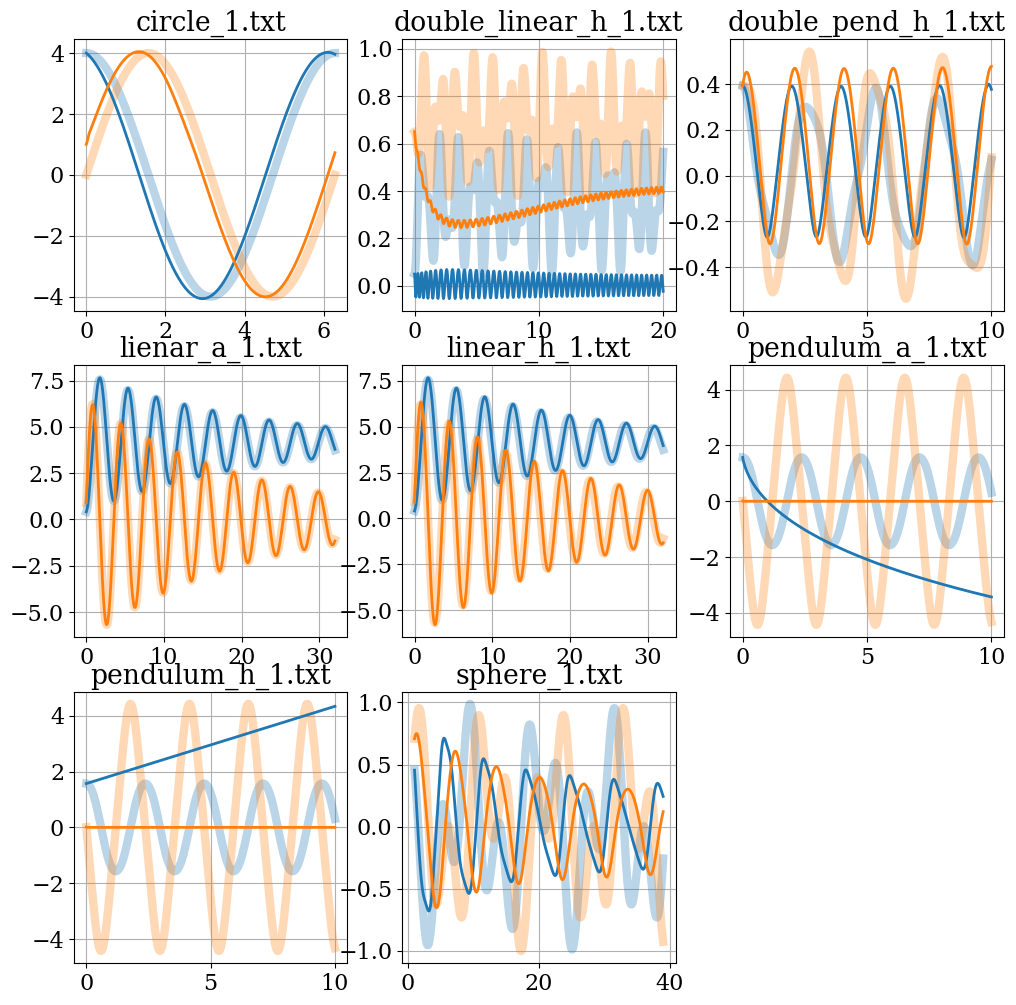

In [14]:
fig = plt.figure(figsize=(12,12))
dstr.rescale = True
dstr.model.beam_size = 5
dstr.model.beam_temperature = .1

for i, (name, data) in enumerate(datasets.items()):
    ax = plt.subplot(math.ceil(n**.5),math.ceil(n**.5),i+1)
    #if i==5: break
    print(i, end=' ')
    times = data[:,1]
    trajectories = []
    for dim in range(2, min(data.shape[1],6)):
        trajectories.append(data[:,dim][:,None])
    trajectory = np.concatenate(trajectories, axis=1)

    for dim in range(len(trajectory[0]))[:2]:
        ax.plot(times, trajectory[:,dim], color=f'C{dim}', label='True', lw=6, alpha=.3)
    candidates = dstr.fit(times, trajectory)
    for tree in candidates[0][:1]:
        print(env.simplifier.readable_tree(tree))
        pred_trajectory = integrate_ode(trajectory[0], times, tree, "solve_ivp", debug=False)
        try:
            for dim in range(len(trajectory[0]))[:2]:
                ax.plot(times, pred_trajectory[:,dim], color=f'C{dim}', label='Pred')
        except: 
            print('Fail', end=' ')
    ax.set_title(name)
plt.savefig(savedir+"oscillators.pdf")
plt.show()

# Play with generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-6.7028*x_0 + 15.9171*x_1

-0.1003*x_1

-2.801*x_1*(-0.3315*x_1**2 + 0.4822*x_1)

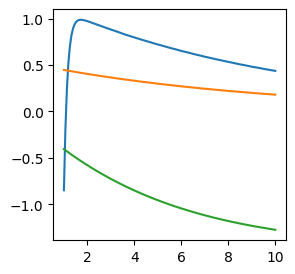

-18.1134*x_0*x_2 - 2.1251*x_1 - 2.2435*x_2

0.1311*x_0 + 10.6416*x_2**2

-12.6321*x_2

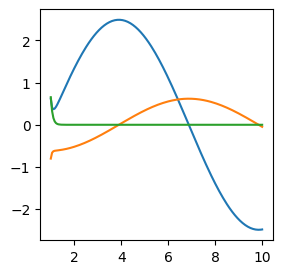

-0.3028*x_1 + 0.4561*x_2 - 0.0654/(0.0622 - 9.499*x_1)

0.0191 - 0.057*x_1

0.5693*x_0 + 2.7745*x_3 - 0.3236*(x_0 + 0.306)**2

0.1715*sin(4.6603*x_2 - 0.6205) - 7.6437*sin(46.8037*x_0*(-x_0 - 0.016)**2 - 15.859*x_0)

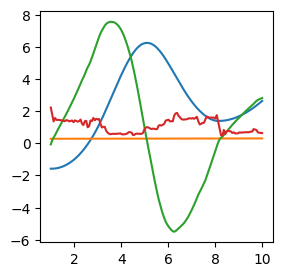

-0.0697*x_0

x_2**2*(4.6542*x_2 - 2.6462)

-0.2177*x_2**2

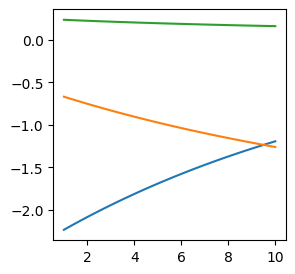

1.9519*x_1 + 0.127*x_2**2 + 0.7538*x_2 - 3.8082*x_4

-8.2692*x_1

-14.4134*x_2 - 0.1588*x_4

(-17.1896*x_1 + 3.8876*x_2 - 0.1727)*sin(18.7878*x_4 - 1.1624)

-17.8992*x_2

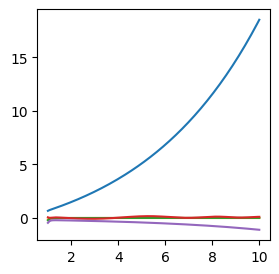

-0.1676*(x_2 + 0.1141)**2 - 0.0572*sin(3.8131*x_4 + 0.8775)

-7.37*x_2

-3.0627*x_0*x_1 - 2.452*x_4 + 1.5782

0.2991*x_4 + 0.1585

5.1239*x_2 + 0.3822

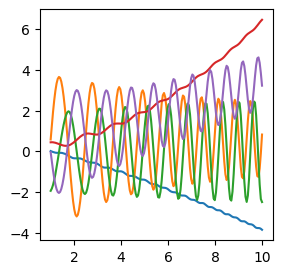

x_0*(0.2367*x_0 + 10.9898)

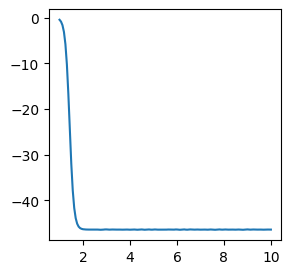

-12.0393*x_0*x_1

(-52.2684*x_2 - 0.1907)*sin(3.9184*x_2 - 0.5062)

0.141*x_1

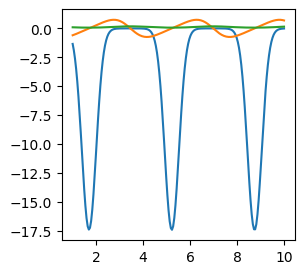

4.2661*x_1

-1.0713*x_0 + 0.3713/(12.9899*x_0/(1.116*x_1 - 0.1886) - 12.2046)

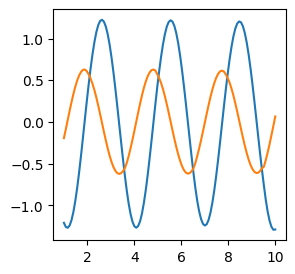

8.0927*x_1**2 + 9.2237*x_1

x_0*(-0.3812*x_1**2 - 6.0135*sin(3.0114*x_1 - 17.0061))

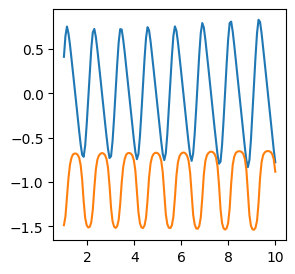

31.2
0.13513513513513514


In [ ]:
from notebook_utils import *
%load_ext autoreload
%autoreload 2

parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)    
args = parser.parse_args(args=[])
args.debug = False
args.min_dimension = 1
args.max_dimension = 6
#args.sign_as_token = True
#args.prob_t = 0
#args.max_dimension = 4
#args.max_unary_ops = 4
#args.max_unary_depth = 4
#args.prob_prefactor = 1
#args.use_controller = True
#args.expand=False
#args.max_trajectory_value = 1e2
#args.max_unary_depth = 5
#args.expand = False
#args.prob_prefactor = 1
#args.time_range = 10
#args.operators_to_use = "add:3,mul:1,inv:1,sin:1,id:3"
#args.discard_stationary_trajectory_prob = 1
    
env = FunctionEnvironment(args)

env.rng = np.random.RandomState()
i=0
lens = []
trees = []
for itotal in range(1000):
    try: samples, error = env._gen_expr(train=True)
    except MyTimeoutError: continue
    if i==10: break
    if not error:
        tree = samples["tree"]
        lens.append(len(tree.prefix().split(',')))
        tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
        for expr in tree_sympy:
            display(expr)
        plt.figure(figsize=(3,3))
        for dim in range(samples["infos"]["dimension"]): 
            #print(samples["trajectory"][-10:])
            plt.plot(samples["times"], samples["trajectory"][:, dim])
        plt.show()
        trees.append(tree)
        i+=1
print(np.mean(lens))
print((i/(itotal)))


In [18]:
import sympy as sp
expr = sp.parse_expr(env.simplifier.prefix_to_sympy_compatible_infix('div,x_0,x_0'.split(',')))
env.simplifier.sympy_expr_to_tree(expr)

1

In [37]:
env.equation_encoder.decode('add,mul,-0.0300,x_2,mul,-1.2829,x_1,|,add,mul,-0.0974,x_2,add,mul,-1.6359,x_0,mul,-16.1755,x_1,|,mul,x_0,add,mul,3.3234,x_2,mul,-0.1386,x_0'.split(','))

-0.0300 * x_2 + -1.2829 * x_1 | -0.0974 * x_2 + -1.6359 * x_0 + -16.1755 * x_1 | x_0 * (3.3234 * x_2 + -0.1386 * x_0)

In [9]:
math.frexp(100)

(0.78125, 7)

In [159]:
rng = np.random.RandomState(18)
from scipy.integrate import odeint, solve_ivp
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=rng, dimension=2, nb_unary_ops=1)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = rng.randn(dimension)
t = np.linspace(1,2,100)

#trajectory = integrate_ode(y0, t, tree, ode_integrator='odeint', debug=True)
trajectory = integrate_ode(y0, t, tree, ode_integrator='jax', debug=True)

for dim in range(dimension):
    plt.plot(t,trajectory[:,dim])


System :


42.3801*x_0*(1 - 0.0819*x_0)**2*(0.82*x_0 + 0.82*x_1) - 0.606

-4.21*x_0 + 0.332*x_1*(9.39*x_1 + 0.0744*(0.9213*x_0 + 1)**2) - 4.21*x_1 - 0.544

AttributeError: module 'symbolicregression.envs' has no attribute 'Simplifier'

In [57]:
trajectory[0]

Array([-0.20161551,  0.4996451 ], dtype=float32, weak_type=True)

In [26]:
tree_sympy

[16.58*x_0*x_1**2*cos(4.85*x_0 + 0.55) - 0.5,
 x_1*(-0.119*x_0*x_1 - 5.7*x_0 - 0.119/(1.86*x_0 + 0.55)) + 0.314]

In [28]:
from symbolicregression.envs.export_jax import *
dimension=2
tree = tree_sympy[0]
symbols = list(tree.free_symbols)
jax_trees, jax_params = [], []
for tree in tree_sympy:
    jax_tree, jax_param = sympy2jax(tree, symbols)
    jax_trees.append(jax_tree)
    jax_params.append(jax_param)
def func(x):
    print(jax_trees[0](x, jax_params[0]).shape)
    return jax.numpy.concatenate([jax_tree(x, jax_param).reshape(-1,1) for jax_tree, jax_param in zip(jax_trees, jax_params)], axis=1)

In [29]:
import jax.random as random
key = random.PRNGKey(0)
X = random.normal(key, (10, 2))
func(X).shape

(10,)


(10, 2)

In [77]:
def f(t, y):
    return tree_jax(*y)

y0 = np.random.randn(dimension)
t = np.linspace(1,2,100)
trajectory = integrate_ode(y0, t, tree, ode_integrator='jax', debug=True)

AttributeError: 'Add' object has no attribute 'infix'

In [ ]:
from scipy.integrate import odeint, solve_ivp
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=env.rng, dimension=2)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = np.random.randn(dimension)
t = (0,1)
def func(t,y):
    return tree.val([y],t)[0]
while True:
    import warnings
    with warnings.catch_warnings(record=True) as caught_warnings:
        #sol = odeint(func, y0, t)
        sol = solve_ivp(func, t, y0)
    if caught_warnings:
        print('hi')
        print('Warning: ', caught_warnings[0].message)
        continue
    break

t = sol.t
sol = sol.y.T
for dim in range(dimension):
    plt.plot(t,sol[:,dim])


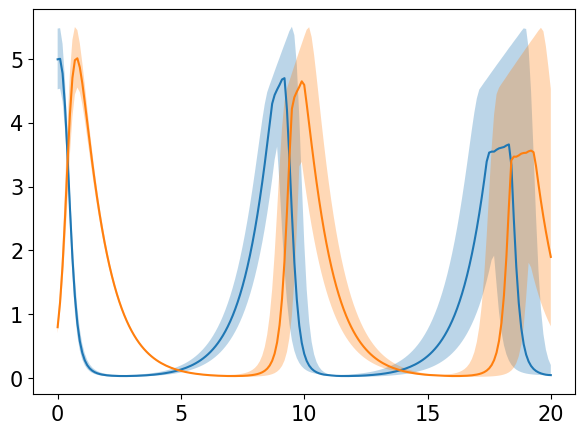

In [6]:
from numbalsoda import lsoda_sig, lsoda
from matplotlib import pyplot as plt
import numpy as np
import numba as nb

@nb.cfunc(lsoda_sig)
def f(t, u, du, p):
    du[0] = u[0]-u[0]*u[1]
    du[1] = u[0]*u[1]-u[1]

funcptr = f.address
t_eval = np.linspace(0.0,20.0,201)
np.random.seed(0)

def main(n):
    u1 = np.empty((n,len(t_eval)), np.float64)
    u2 = np.empty((n,len(t_eval)), np.float64)
    for i in nb.prange(n):
        u0 = np.empty((2,), np.float64)
        u0[0] = np.random.uniform(4.5,5.5)
        u0[1] = np.random.uniform(0.7,0.9)
        usol, success = lsoda(funcptr, u0, t_eval, rtol = 1e-8, atol = 1e-8)
        u1[i] = usol[:,0]
        u2[i] = usol[:,1]
    return u1, u2

u1, u2 = main(10000)

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])
low, med, high = np.quantile(u1,(.025,.5,.975),axis=0)
ax.plot(t_eval,med)
ax.fill_between(t_eval,low,high,alpha=0.3)
low, med, high = np.quantile(u2,(.025,.5,.975),axis=0)
ax.plot(t_eval,med)
ax.fill_between(t_eval,low,high,alpha=0.3)
plt.show()

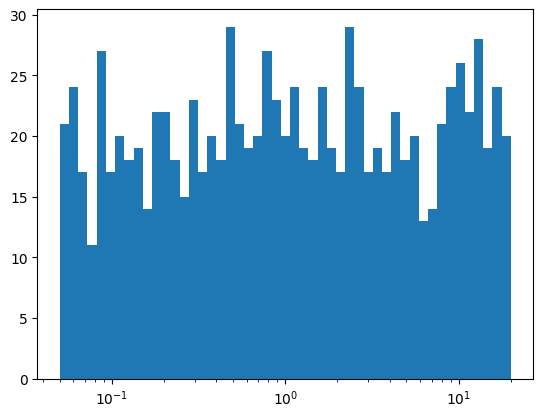

In [ ]:
parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)    
args = parser.parse_args(args=[])
args.max_exponent_prefactor = 1
args.debug=False
args.ode_integrator = 'solve_ivp'
    
env = FunctionEnvironment(args)

rng = np.random.RandomState(0)
nums = []
for _ in range(1000):
    nums.append(abs(float(env.generator.generate_float(rng))))
# make a logartihmic histogram
nums = np.array(nums)
nums = nums[nums>0]
bins = np.logspace(np.log10(min(nums)),np.log10(max(nums)), 50)
plt.hist(nums, bins=bins)
plt.xscale('log')